In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
import numpy as np
from model import PositionalEncoding, get_bou_features, find_best_shift, get_img_tokens
from model import IterWholeFirst
from einops import rearrange
import torchvision.transforms as T
from PIL import Image
from featup.util import norm, unnorm
from featup.plotting import plot_feats
from collections import OrderedDict
from DETR_model import DinoDETR
import time
from dataloader import CircleDataset, CircleRaw
from torch.utils.data import DataLoader
from polygon import SoftPolygon
import matplotlib.pyplot as plt
from preprocess_utensils import get_boundary_iou
from dataloader import normalize_image
import random

In [10]:
raw_set = CircleRaw()
data_set = CircleDataset()
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [11]:
(
    pre_idx,
    fir_img,
    fir_sgm,
    fir_bou,
    pre_img,
    pre_sgm,
    pre_bou,
    cur_img,
    cur_sgm,
    cur_bou,
) = next(iter(data_loader))
pre_idx

tensor([6])

In [4]:
model = DinoDETR()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [26]:
bou = model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
)


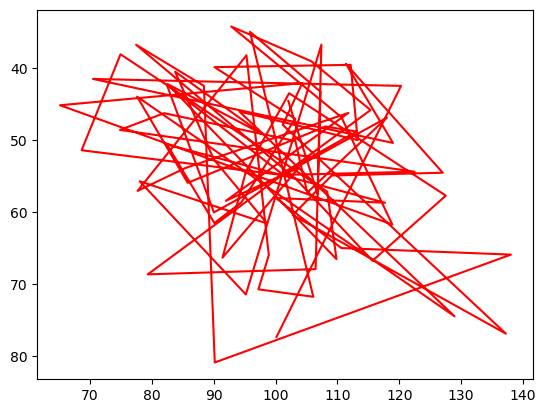

In [31]:
# plot the bou
plt.figure()
plt.plot(
    bou[0, :, 0].detach().cpu().numpy(),
    bou[0, :, 1].detach().cpu().numpy(),
    "r",
)
# flip the y axis
plt.gca().invert_yaxis()
plt.show()

In [16]:
soft_polygon = SoftPolygon(0.01, mode="hard_mask").cuda()

In [27]:
polygon = soft_polygon(bou, 224, 224)
polygon.shape, polygon.unique()

(torch.Size([1, 224, 224]),
 tensor([-1.,  1.], device='cuda:0', grad_fn=<Unique2Backward0>))

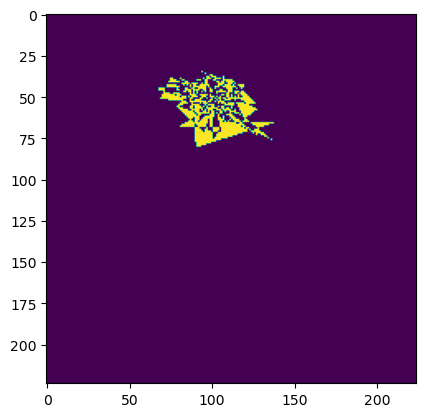

In [28]:
polygon[polygon == -1] = 0
plt.imshow(polygon[0].cpu().detach().numpy())

In [60]:
class TestModel(nn.Module):
    def __init__(self, boundary_num=80, device="cuda", raw_set=CircleRaw()):
        super(TestModel, self).__init__()
        self.pos = raw_set[0][2]
        self.raw_set = raw_set

    def forward(
        self,
        fir_img: torch.Tensor,
        fir_mask: torch.Tensor,
        pre_img: torch.Tensor,
        pre_mask: torch.Tensor,
        cur_img: torch.Tensor,
    ) -> torch.Tensor:
        self.pos += 15
        if self.pos.max().item() > 224:
            self.pos = self.raw_set[0][2]
        return self.pos.float()

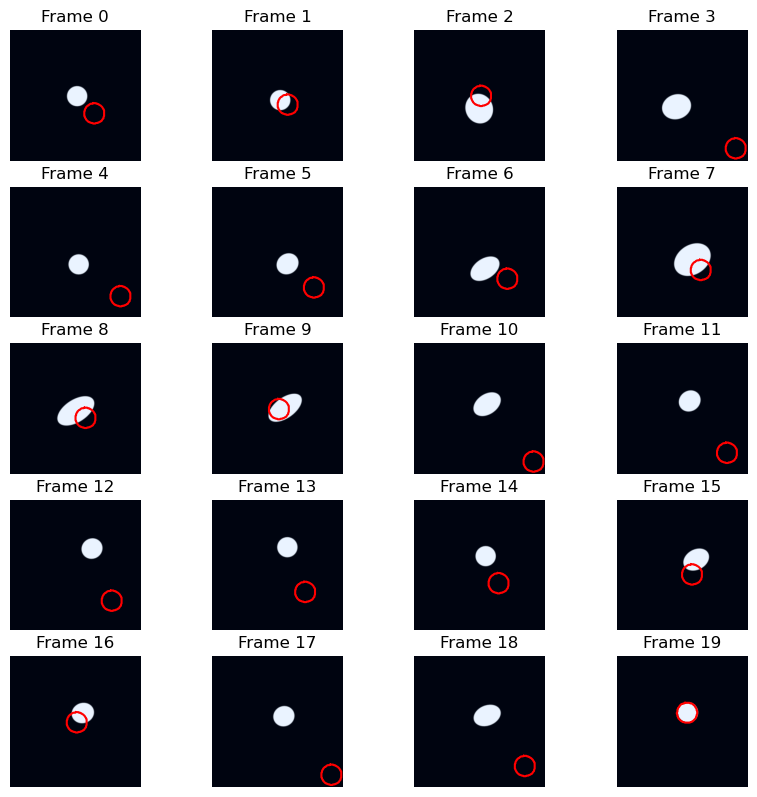

tensor(0.1277)

In [61]:
class ModelInfer:
    def __init__(
        self,
        test_set: torch.utils.data.Dataset,
        is_detr=False,
        device="cuda",
    ) -> None:
        self.test_set = test_set
        self.device = device
        self.infer_results = {}
        self.is_detr = is_detr
        if is_detr:
            self.solf_polygon = SoftPolygon(0.01, mode="hard_mask").to(device)

    def infer_model(self, model: torch.nn.Module):
        model = model.to(self.device)

        def inference_model_at_index(
            model: torch.nn.Module,
            test_dataset: torch.utils.data.Dataset,
            first_index: int,
            end_index: int,
            device="cuda",
        ):
            inference_results = {}
            model = model.to(device)
            model.eval()
            if end_index < first_index:
                step = -1
            else:
                step = 1
            first_img, first_sgm, first_boundary = test_dataset[first_index]
            inference_results[first_index] = first_boundary
            # plt.subplot(10, 4, first_index + 1)
            # plt.imshow(normalize_image(first_img.permute(1, 2, 0)))
            # plt.plot(first_boundary[:, 0], first_boundary[:, 1], "r")
            # plt.axis("off")
            # plt.title(f"Frame {first_index}")
            first_index += step
            pre_boundary = first_boundary
            pre_img = first_img
            # for i in tqdm(range(first_index, end_index + step, step)):
            for i in range(first_index, end_index + step, step):
                curr_img, curr_sgm, curr_boundary = test_dataset[i]
                if not self.is_detr:
                    results = model(
                        first_img.unsqueeze(0).to(device),
                        first_boundary.unsqueeze(0).to(device),
                        pre_img.unsqueeze(0).to(device),
                        curr_img.unsqueeze(0).to(device),
                        pre_boundary.unsqueeze(0).to(device),
                    )
                    pre_boundary = results[-1].int().squeeze(0).clamp(0, 223)
                else:
                    pre_sgm = self.solf_polygon(
                        pre_boundary.unsqueeze(0).to(device).float(),
                        224,
                        224,
                    )
                    pre_sgm[pre_sgm == -1] = 0
                    pre_sgm = pre_sgm.squeeze(0)
                    output = model(
                        first_img.unsqueeze(0).to(device),
                        first_sgm.unsqueeze(0).to(device),
                        pre_img.unsqueeze(0).to(device),
                        pre_sgm.unsqueeze(0).to(device),
                        curr_img.unsqueeze(0).to(device),
                    )
                    pre_boundary = output.int().squeeze(0).clamp(0, 223)
                inference_results[i] = pre_boundary
                pre_img = curr_img
                # plt.subplot(10, 4, i + 1)
                # plt.imshow(normalize_image(curr_img.squeeze(0).permute(1, 2, 0)))
                # plt.plot(
                #     pre_boundary.cpu().numpy()[:, 0],
                #     pre_boundary.cpu().numpy()[:, 1],
                #     "r",
                # )
                # plt.axis("off")
                # plt.title(f"Frame {i}")
            return inference_results

        def inference_model(
            model: torch.nn.Module,
            test_dataset: torch.utils.data.Dataset,
            device="cuda",
        ):
            inference_results = {}
            for i in range(len(test_dataset)):
                tmp_result1 = inference_model_at_index(
                    model, test_dataset, i, 0, device
                )
                tmp_result2 = inference_model_at_index(
                    model, test_dataset, i, len(test_dataset) - 1, device
                )
                inference_results[i] = {**tmp_result1, **tmp_result2}
            return inference_results

        self.infer_results = inference_model(model, self.test_set, self.device)

    def show_infer_result(
        self,
        index: int,
        figsize=(10, 20),
        nrows=10,
        ncols=4,
    ):
        total_iou = 0
        plt.figure(figsize=figsize)
        for i in range(len(self.test_set)):
            plt.subplot(nrows, ncols, i + 1)
            img, sgm, boundary = self.test_set[i]
            plt.imshow(normalize_image(img.permute(1, 2, 0)))
            plt.plot(
                self.infer_results[index][i].cpu()[:, 0],
                self.infer_results[index][i].cpu()[:, 1],
                "r",
            )
            plt.axis("off")
            plt.title(f"Frame {i}")
            total_iou += get_boundary_iou(
                sgm, self.infer_results[index][i].cpu().numpy()
            )
        plt.show()
        return total_iou / len(self.test_set)

    def get_infer_iou(self, index: int):
        total_iou = 0
        for i in range(len(self.test_set)):
            img, sgm, boundary = self.test_set[i]
            total_iou += get_boundary_iou(
                sgm, self.infer_results[index][i].cpu().numpy()
            )
        return total_iou / len(self.test_set)

    def get_boundary(self, index: int):
        if len(self.infer_results) == 0:
            return self.test_set[index][2]
        else:
            random_index = random.randint(0, len(self.infer_results) - 1)
            return self.infer_results[random_index][index]

model = TestModel()
model_infer = ModelInfer(raw_set, is_detr=True)
model_infer.infer_model(model)
model_infer.show_infer_result(19)

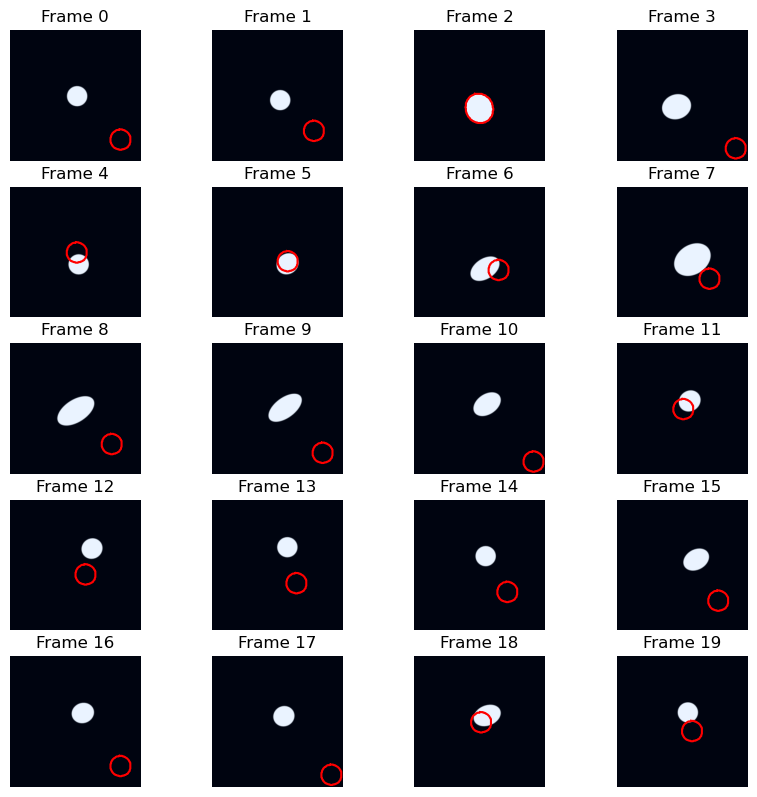

tensor(0.1289)

In [62]:
model_infer.show_infer_result(2)